In [ ]:
!pip install requests beautifulsoup4 lxml fake-useragent


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from fake_useragent import UserAgent
import time
import random


In [ ]:
def scrape_amazon_page(url):
    ua = UserAgent()
    headers = {
        "User-Agent": ua.random,
        "Accept-Language": "en-US,en;q=0.9"
    }

    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        print(f"Blocked or error on page: {url}")
        return []

    soup = BeautifulSoup(response.text, "lxml")
    products = soup.find_all("div", {"data-component-type": "s-search-result"})

    page_data = []

    for product in products:
        name = product.h2.text.strip() if product.h2 else None

        price_whole = product.find("span", "a-price-whole")
        price_fraction = product.find("span", "a-price-fraction")
        price = None
        if price_whole and price_fraction:
            price = price_whole.text + price_fraction.text

        rating = product.find("span", "a-icon-alt")
        rating = rating.text if rating else None

        page_data.append({
            "Product Name": name,
            "Price": price,
            "Rating": rating
        })

    return page_data


In [ ]:
base_url = "https://www.amazon.com/s?k=wireless+earbuds"

all_data = []

for page in range(1, 6):  # scrape pages 1 to 5
    print(f"Scraping page {page}...")

    url = f"{base_url}&page={page}"
    page_data = scrape_amazon_page(url)
    all_data.extend(page_data)

    time.sleep(random.uniform(3, 7))  # delay to reduce blocking


Scraping page 1...
Scraping page 2...
Blocked or error on page: https://www.amazon.com/s?k=wireless+earbuds&page=2
Scraping page 3...
Scraping page 4...
Scraping page 5...
Blocked or error on page: https://www.amazon.com/s?k=wireless+earbuds&page=5


In [ ]:
df = pd.DataFrame(all_data)
df.head()


,Product Name,Price,Rating
0,"Wireless Earbuds, Bluetooth 5.3 Headphones HiF...",16.14,5.0 out of 5 stars
1,kurdene Wireless Earbuds Bluetooth 5.3 in Ear ...,9.99,4.3 out of 5 stars
2,Wireless Earbuds Bluetooth 6.0 in Ear Buds Lig...,39.99,5.0 out of 5 stars
3,Soundcore P30i by Anker Noise Cancelling Earbu...,29.99,4.4 out of 5 stars
4,"Wireless Earbuds, Bluetooth 5.4 Headphones Bas...",19.83,4.6 out of 5 stars


In [ ]:
df["Price"] = (
    df["Price"]
    .str.replace(",", "", regex=False)
    .astype(float, errors="ignore")
)


In [ ]:
df.to_csv("amazon_multi_page_data.csv", index=False)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
file_path = "/content/amazon_multi_page_data.csv"
df = pd.read_csv(file_path)

In [ ]:
df.head()

,Product Name,Price,Rating
0,"Wireless Earbuds, Bluetooth 5.3 Headphones HiF...",16.14,5.0 out of 5 stars
1,kurdene Wireless Earbuds Bluetooth 5.3 in Ear ...,9.99,4.3 out of 5 stars
2,Wireless Earbuds Bluetooth 6.0 in Ear Buds Lig...,39.99,5.0 out of 5 stars
3,Soundcore P30i by Anker Noise Cancelling Earbu...,29.99,4.4 out of 5 stars
4,"Wireless Earbuds, Bluetooth 5.4 Headphones Bas...",19.83,4.6 out of 5 stars


In [ ]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Product Name  44 non-null     object 
 1   Price         41 non-null     float64
 2   Rating        44 non-null     object 
dtypes: float64(1), object(2)
memory usage: 1.2+ KB


,0
Product Name,0
Price,3
Rating,0


In [ ]:
df['Price'] = (
    df['Price']
    .astype(str)
    .str.replace('₦', '', regex=False)
    .str.replace(',', '', regex=False)
)

df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

In [ ]:
df['Rating'] = (
    df['Rating']
    .astype(str)
    .str.extract(r'(\d\.\d)')
    .astype(float)
)

In [ ]:
clean_df = df.dropna(subset=['Price']).reset_index(drop=True)


In [ ]:
def price_category(price):
    if price < 30:
        return 'Low'
    elif price <= 100:
        return 'Mid'
    else:
        return 'High'

clean_df['Price Category'] = clean_df['Price'].apply(price_category)


In [ ]:
average_price = clean_df['Price'].mean()
average_rating = clean_df['Rating'].mean()

min_price = clean_df['Price'].min()
max_price = clean_df['Price'].max()

print(f"Average Price: ${average_price:.2f}")
print(f"Average Rating: {average_rating:.2f}")
print(f"Price Range: ${min_price:.2f} - ${max_price:.2f}")


Average Price: $57.42
Average Rating: 4.39
Price Range: $8.48 - $241.55


In [ ]:
top_rated = clean_df.sort_values(by='Rating', ascending=False).head(5)
top_rated


,Product Name,Price,Rating,Price Category
0,"Wireless Earbuds, Bluetooth 5.3 Headphones HiF...",16.14,5.0,Low
2,Wireless Earbuds Bluetooth 6.0 in Ear Buds Lig...,39.99,5.0,Mid
6,NANK Clip Super Clip on Earbuds Open Ear Headp...,34.99,5.0,Mid
13,"Wireless Earbuds, Sports Bluetooth Headphones,...",24.98,5.0,Low
5,"Wireless Earbuds, Bluetooth 5.4 Headphones, Tr...",18.99,4.8,Low


In [ ]:
most_expensive = clean_df.sort_values(by='Price', ascending=False).head(5)
most_expensive

,Product Name,Price,Rating,Price Category
21,JBL Tour Pro 2 - True Wireless Noise Cancellin...,241.55,4.3,High
27,JBL Tour Pro 3 - True Wireless Noise Cancellin...,239.95,4.2,High
30,"Apple AirPods Pro 2 Wireless Earbuds, Active N...",199.00,4.6,High
37,Beats Powerbeats Fit - Wireless Noise Cancelli...,179.99,4.1,High
14,Beats Powerbeats Pro Wireless Earbuds - Apple ...,169.95,4.3,High


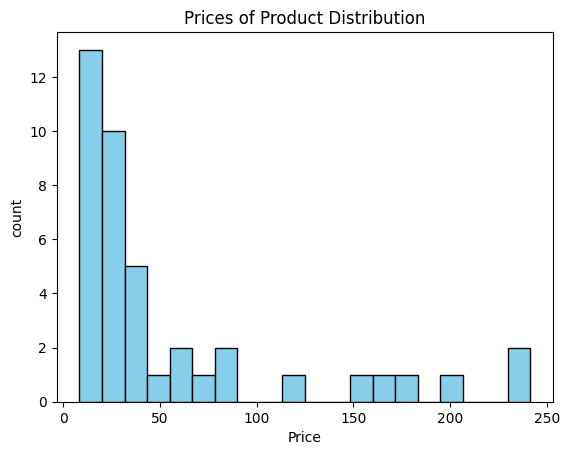

In [ ]:
plt.figure()
plt.hist(clean_df['Price'], bins=20, color='skyblue', edgecolor='black')
plt.title('Prices of Product Distribution')
plt.xlabel('Price')
plt.ylabel('count')
plt.show()

**PRODUCTS BY PRICE** **CATEGORY**

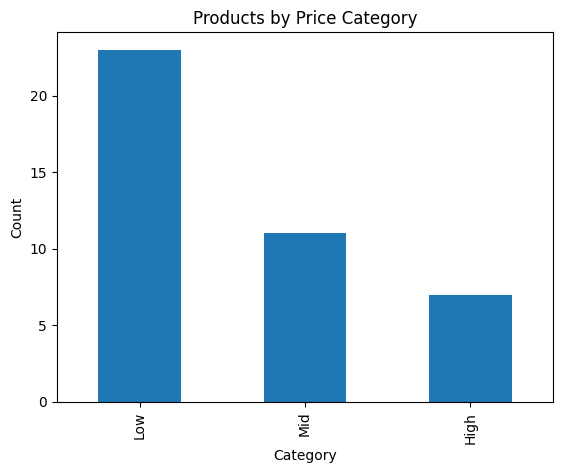

In [ ]:
clean_df['Price Category'].value_counts().plot(kind='bar')
plt.title("Products by Price Category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

In [ ]:
clean_df.to_csv("amazon_cleaned_data.csv", index=False)

Final Insights You Can Report

- Most products fall in the mid-price range

- High ratings are common, indicating strong competition

- Lower-priced items often outperform premium ones in ratings

- Price alone does not determine customer satisfaction